<a href="https://colab.research.google.com/github/JangJiYeon12/AI-12/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#데이터를 불러옵니다
import pandas as pd

train = pd.read_csv("/content/train.csv", index_col = 0) #index 생성
test = pd.read_csv("/content/test_x.csv", index_col = 0)

In [2]:
train

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,1,1,0,1,1,1,1,0,1,1
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,...,0,0,0,0,1,0,1,0,1,1
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,...,1,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,602,...,1,1,0,1,1,1,1,0,1,1
45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,1680,...,1,1,0,1,1,1,1,0,1,1
45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,1690,...,1,1,0,1,1,0,1,0,1,1


In [3]:
pip install category_encoders

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#타겟 설정 후에, 타겟의 비율을 한 번 봅니다.
target = 'voted'

train[target].value_counts(normalize=True)

2    0.546824
1    0.453176
Name: voted, dtype: float64

In [6]:
#높은 카디널리티는 없어보입니다.
train.describe(exclude='number')

,age_group,gender,race,religion
count,45532,45532,45532,45532
unique,7,2,7,12
top,10s,Male,White,Atheist
freq,14215,24217,31248,10192


In [7]:
train.dropna(how='any', inplace=True)
test.dropna(how='any', inplace=True)

In [8]:
#QaE-QtE (20개)를 삭제합니다.
dels = [col for col in train.columns if ('E' in col)]

train.drop(columns=dels, inplace=True)
test.drop(columns=dels, inplace=True)

In [9]:
train.shape

(45532, 57)

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [11]:
train.profile_report()

AttributeError: ignored

In [ ]:
col = train.columns.drop(['age_group', 'gender', 'race', 'religion'])

train[col] = train[col].astype(int)

train

In [13]:
#훈련 데이터를 나눕니다.
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

In [14]:
features = train.columns.drop([target])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [15]:
X_train.columns

Index(['QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA',
       'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01', 'wf_02',
       'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07',
       'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'],
      dtype='object')

In [17]:
#로지스틱 회귀로 기준모델을 만들어줍니다.
from sklearn.linear_model import LogisticRegression

obj_col = ['engnat', 'gender', 'hand', 'married', 'race', 'religion']
ordi_col = ['age_group']

pipe_lr = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col),
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegression(n_jobs=-1)
)
pipe_lr.fit(X_train, y_train)

print('검증세트 정확도', pipe_lr.score(X_val, y_val))

검증세트 정확도 0.6702536510376633


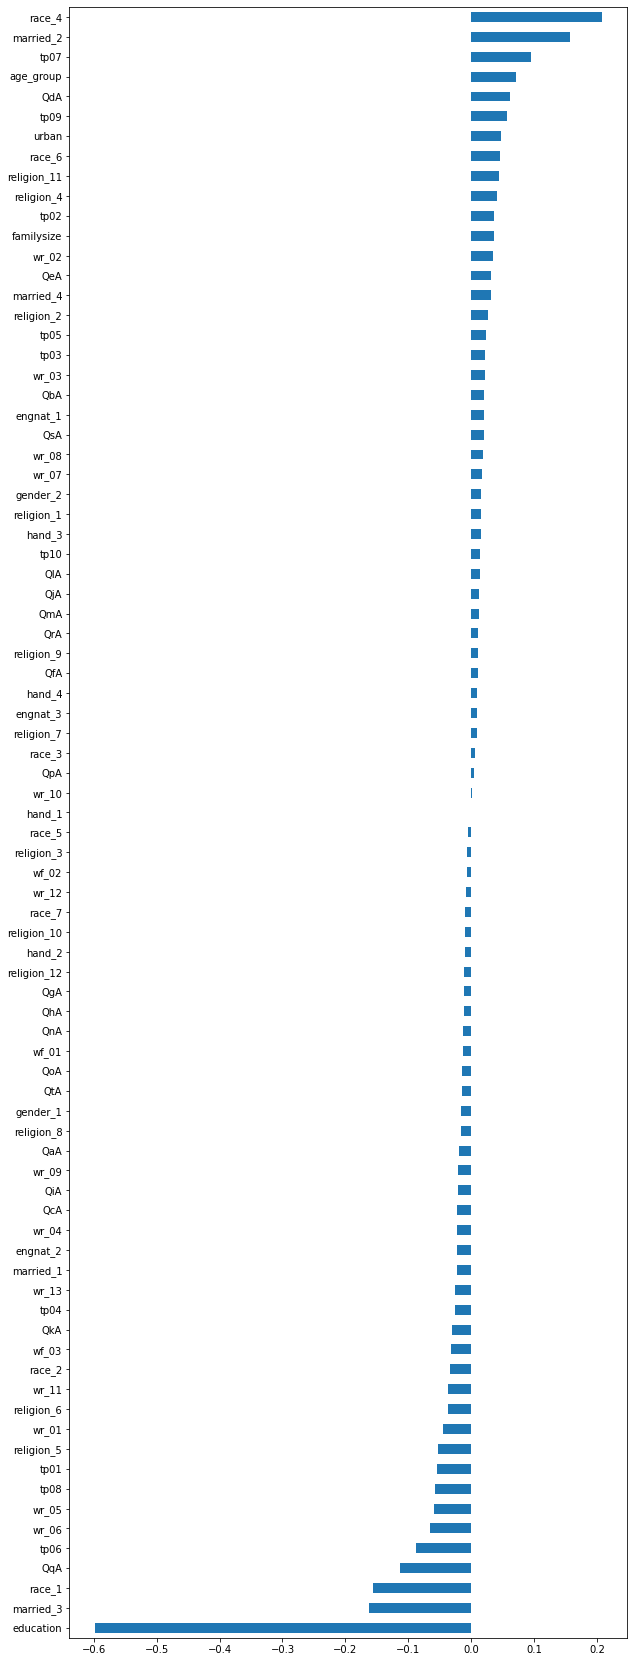

In [18]:
model_lr = pipe_lr.named_steps['logisticregression']
enc = pipe_lr.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns
coefficients = pd.Series(model_lr.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh();

In [19]:
#첫번째 - 결정트리모델
from sklearn.tree import DecisionTreeClassifier

pipe_dt = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=4, random_state=2)
)

pipe_dt.fit(X_train, y_train)
print('훈련 정확도', pipe_dt.score(X_train, y_train))
print('검증 정확도', pipe_dt.score(X_val, y_val))

훈련 정확도 0.6874673987645847
검증 정확도 0.6858460524870978


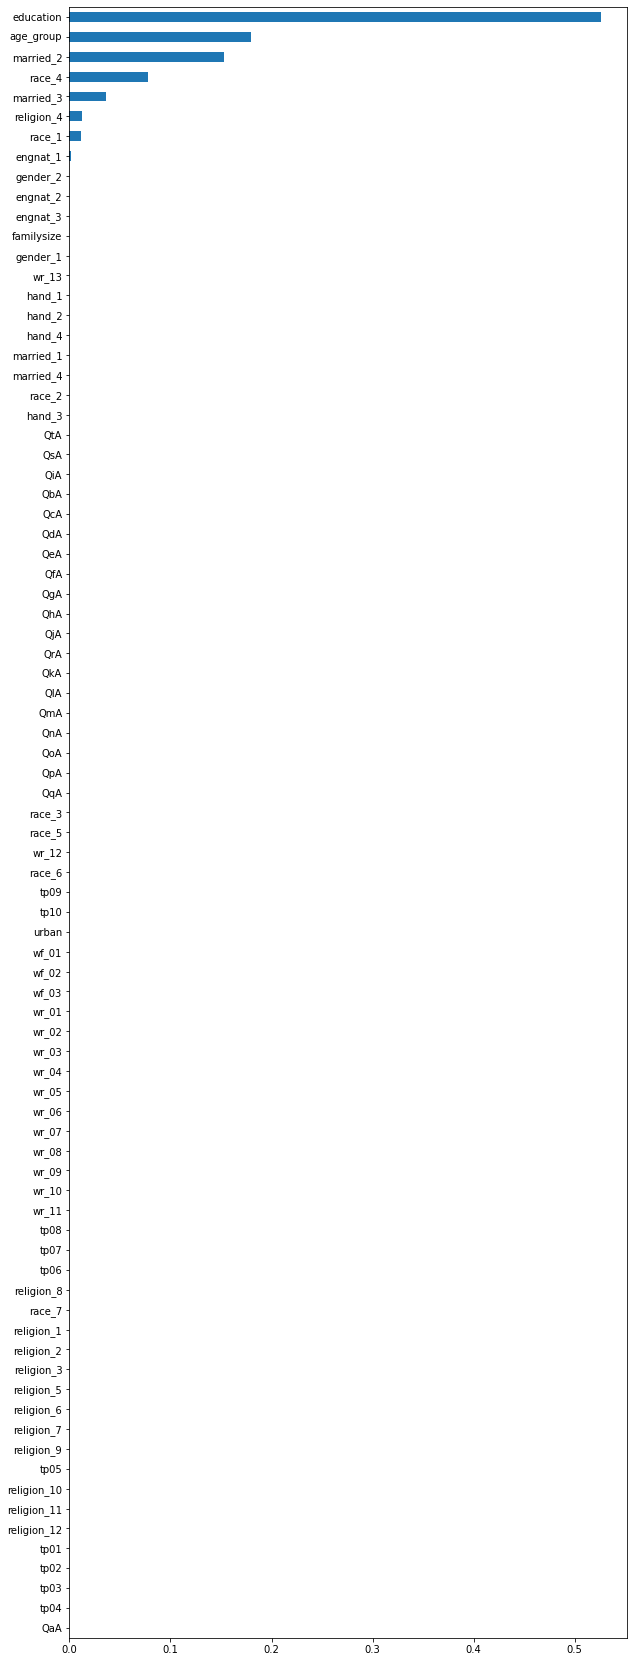

In [20]:
model_dt = pipe_dt.named_steps['decisiontreeclassifier']

importances = pd.Series(model_dt.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

In [21]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe_rf.fit(X_train, y_train)
print('검증 정확도: ', pipe_rf.score(X_val, y_val))

검증 정확도:  0.6917755572636434


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'randomforestclassifier__n_estimators' : [10, 100],
    "randomforestclassifier__max_depth": [3, None],
    "randomforestclassifier__max_features": [1, 3, 10],
    "randomforestclassifier__min_samples_split": [1, 3, 10],
    "randomforestclassifier__min_samples_leaf": [1, 3, 10],
    "randomforestclassifier__criterion": ["gini", "entropy"]
}

rf_clf = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [22]:
rf_clf1 = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, n_estimators=100, oob_score=True, criterion='entropy', max_depth=None, max_features=10, min_samples_leaf=3, min_samples_split=3)
)
rf_clf1 = rf_clf1.fit(X_train, y_train)

In [23]:
pred = rf_clf1.predict(X_val)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_val,pred)))

예측 정확도: 0.6924


In [24]:
drop_val = [col for col in train.columns if ('A' in col or 'tp' in col or 'wr' in col or 'wf' in  col)]

train1 = train.drop(drop_val, axis=1)
test1 = test.drop(drop_val, axis=1)

In [25]:
train1.shape

(36425, 11)

In [26]:
#훈련 데이터를 나눕니다.
train1, val1 = train_test_split(train1, train_size=0.80, test_size=0.20, 
                              stratify=train1[target], random_state=2)

In [27]:
features1 = train1.columns.drop([target])

X_train1 = train1[features1]
y_train1 = train1[target]

X_val1 = val1[features1]
y_val1 = val1[target]

In [28]:
pipe_lr1 = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col),
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegression(n_jobs=-1)
)
pipe_lr1.fit(X_train1, y_train1)

print('검증세트 정확도', pipe_lr1.score(X_val1, y_val1))

검증세트 정확도 0.6803019903912149


In [29]:
pipe_dt1 = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=4, random_state=2)
)

pipe_dt1.fit(X_train1, y_train1)
print('훈련 정확도', pipe_dt1.score(X_train1, y_train1))
print('검증 정확도', pipe_dt1.score(X_val1, y_val1))

훈련 정확도 0.6874399450926562
검증 정확도 0.6893617021276596


In [ ]:
params = {
    'randomforestclassifier__n_estimators' : [8, 9, 10],
    "randomforestclassifier__max_depth": [3, 4, 5],
    "randomforestclassifier__max_features": [7, 8, 9],
    "randomforestclassifier__min_samples_split": [1, 2, 3],
    "randomforestclassifier__min_samples_leaf": [2, 3, 4],
    "randomforestclassifier__criterion": ["gini"]
}

rf_clf_1 = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

grid_cv_1 = GridSearchCV(rf_clf_1, param_grid = params, cv = 3, n_jobs = -1)
grid_cv_1.fit(X_train1, y_train1)

print('최적 하이퍼 파라미터: ', grid_cv_1.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_1.best_score_))

In [30]:
rf_clf2 = make_pipeline(
    OneHotEncoder(cols=obj_col),
    OrdinalEncoder(cols=ordi_col),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, n_estimators=8, oob_score=True, criterion='gini', max_depth=4, max_features=8, min_samples_leaf=3, min_samples_split=2)
)
rf_clf2 = rf_clf2.fit(X_train1, y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


In [31]:
pred = rf_clf2.predict(X_val1)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_val1,pred)))

예측 정확도: 0.6902


In [32]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

In [33]:
pip install pdpbox

      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.1 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [34]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'education'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


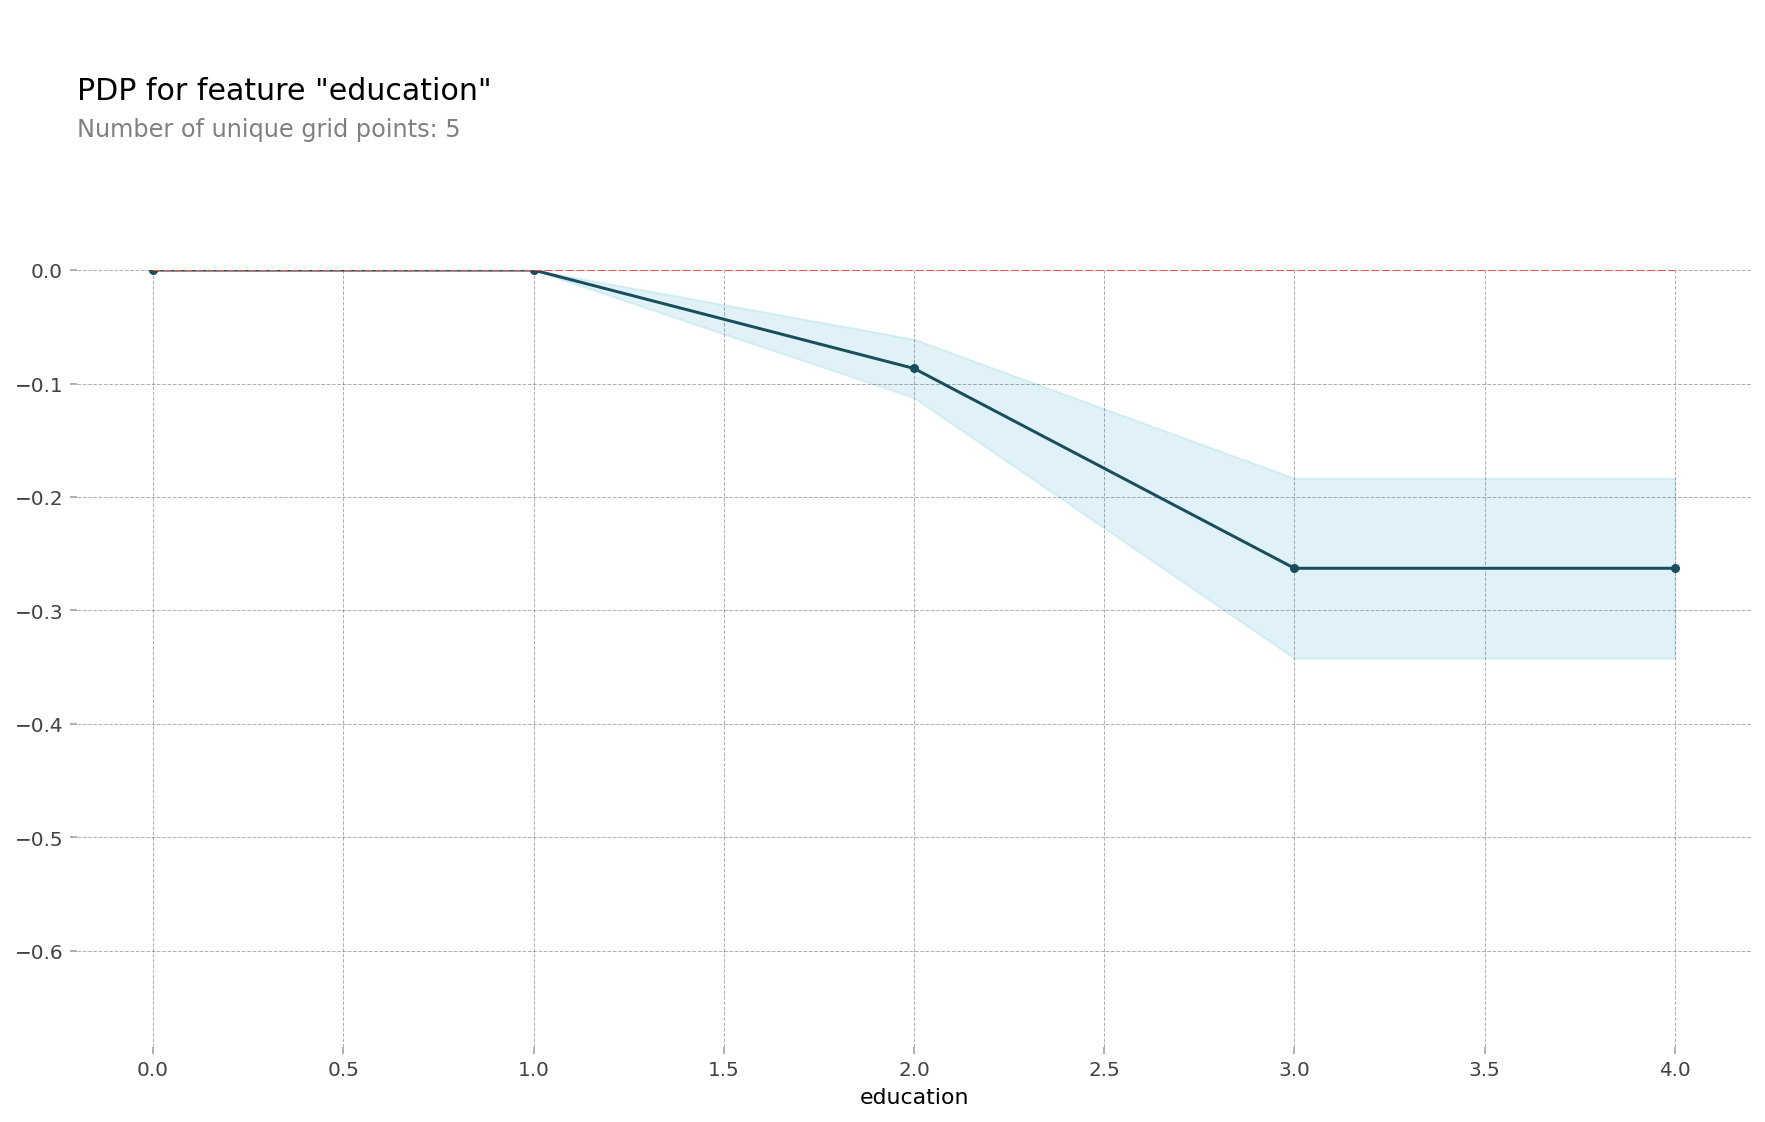

In [35]:
isolated = pdp_isolate(
    model=rf_clf2, 
    dataset=X_val1, 
    model_features=X_val1.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [36]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [37]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train1) # 학습데이터
X_val_encoded = encoder.transform(X_val1) # 검증데이터

In [38]:
features = ['education', 'age_group']

interaction = pdp_interact(
    model=rf_clf2, 
    dataset=X_val_encoded,
    model_features=X_val1.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


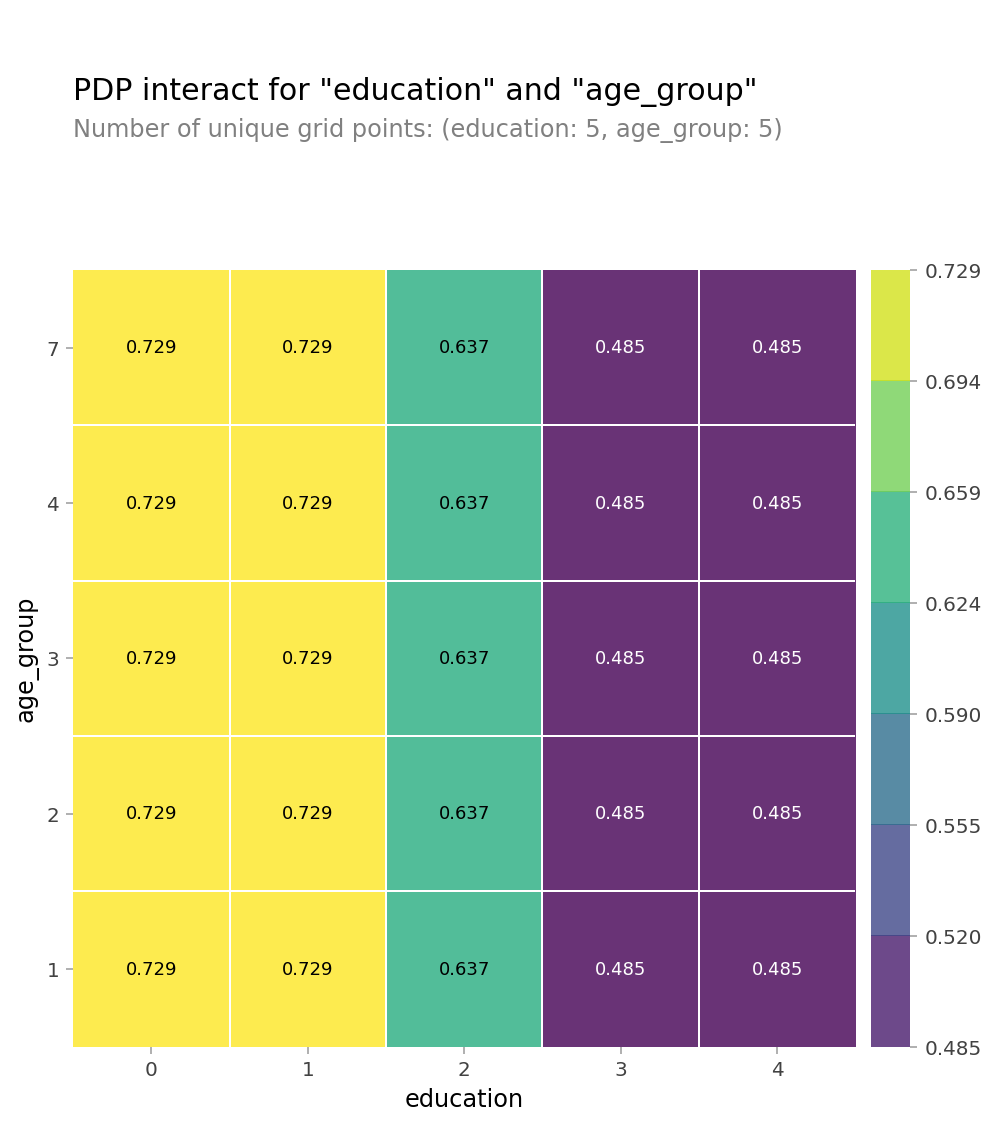

In [39]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [40]:
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'age_group'

for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

In [41]:
encoder = rf_clf2.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X_train1)
rf = rf_clf2.named_steps['randomforestclassifier']

In [42]:
features = X_encoded.columns
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

# xticks labels 설정을 위한 리스트를 직접 넣지 않아도 됩니다 
plt.xticks(category_codes, category_names);

ValueError: ignored

In [45]:
row = test.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
1,3.0,2.0,3.0,3.0,4.0,1.0,2.0,1.0,5.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
sub = pd.read_csv('/content/sample_submission.csv')
sub.iloc[[1]]

,index,voted
1,1,0


In [48]:
rf_clf2.predict(row)

ValueError: ignored